In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [2]:
code_book = pd.read_csv('../data/yougov_codesheet_alignment.tsv', sep='\t')
ename_lut = {vn:en for vn, en in code_book.loc[code_book.ename.notnull(), ['var_name', 'ename']].values}

In [3]:
tmp = code_book.query('ename.notnull()')
scale_lut = {}
for ss, df in tmp.loc[tmp.ename.str.contains('hitop') & ~tmp.ename.str.contains('today')].groupby('subscale'):
    scale_name = ss.replace(" ", "_").replace("/", "_").replace("-", "_")
    items = df.ename.values
    scale_lut[scale_name] = items

In [4]:
dat = pd.read_csv('../data/NIMH0007_interim_num_OUTPUT.csv', dtype={'caseid':str}, engine='python')
# drop the .0 that pandas appends for some reason
dat['caseid'] = dat.caseid.str[:-2]
dat = dat.rename(ename_lut, axis=1)

In [5]:
# clean mood diagnosis
dat['mood_dx'] = np.nan
dat['n_mood_dx'] = (dat.loc[:, ['FNM_Q25_1', 'FNM_Q25_2', 'FNM_Q25_3', 'FNM_Q25_4', 'FNM_Q25_5', 'FNM_Q25_6']]==1).sum(1)
dat.loc[dat.FNM_Q25_955 == 1, 'mood_dx'] = 'other'
dat.loc[dat.FNM_Q25_1 == 1, 'mood_dx'] = 'mdd'
dat.loc[dat.FNM_Q25_2 == 1, 'mood_dx'] = 'persistent'
dat.loc[dat.FNM_Q25_3 == 1, 'mood_dx'] = 'premenstrual'
dat.loc[dat.FNM_Q25_4 == 1, 'mood_dx'] = 'bipolarI'
dat.loc[dat.FNM_Q25_5 == 1, 'mood_dx'] = 'bipolarII'
dat.loc[dat.FNM_Q25_6 == 1, 'mood_dx'] = 'cyclothymic'
dat.loc[dat.n_mood_dx > 1, 'mood_dx'] = 'multiple'

# clean other mood columns
dat.loc[dat.mood_years == 999, 'mood_years'] = np.nan
dat.loc[(dat.mood_bothered == 999) | (dat.mood_bothered == 2), 'mood_bothered'] = False
dat.loc[dat.mood_bothered == 1, 'mood_bothered'] = True
dat.mood_bothered = dat.mood_bothered.astype(bool)

In [6]:
# clean anxiety diagnosis
dat['anxiety_dx'] = np.nan
dat['n_anxiety_dx'] = (dat.loc[:, ['FNM_Q30_m_1',
                                   'FNM_Q30_m_2',
                                   'FNM_Q30_m_3', 
                                   'FNM_Q30_m_4', 
                                   'FNM_Q30_m_5',
                                   'FNM_Q30_m_6',
                                   'FNM_Q30_m_7',
                                   'FNM_Q30_m_8',]]==1).sum(1)
dat.loc[dat.FNM_Q30_m_955 == 1, 'anxiety_dx'] = 'other'
dat.loc[dat.FNM_Q30_m_1 == 1, 'anxiety_dx'] = 'gad'
dat.loc[dat.FNM_Q30_m_2 == 1, 'anxiety_dx'] = 'separation'
dat.loc[dat.FNM_Q30_m_3 == 1, 'anxiety_dx'] = 'agoraphobia'
dat.loc[dat.FNM_Q30_m_4 == 1, 'anxiety_dx'] = 'phobia'
dat.loc[dat.FNM_Q30_m_5 == 1, 'anxiety_dx'] = 'social'
dat.loc[dat.FNM_Q30_m_6 == 1, 'anxiety_dx'] = 'panic_disorder'
dat.loc[dat.FNM_Q30_m_7 == 1, 'anxiety_dx'] = 'panic_attack'
dat.loc[dat.FNM_Q30_m_8 == 1, 'anxiety_dx'] = 'mutism'

dat.loc[dat.n_anxiety_dx > 1, 'anxiety_dx'] = 'multiple'

# clean other mood columns
dat.loc[dat.anxiety_years == 999, 'anxiety_years'] = np.nan
dat.loc[(dat.anxiety_bothered == 999) | (dat.anxiety_bothered == 2), 'anxiety_bothered'] = False
dat.loc[dat.anxiety_bothered == 1, 'anxiety_bothered'] = True
dat.anxiety_bothered = dat.anxiety_bothered.astype(bool)

In [7]:
# clean attention diagnosis
dat['attention_dx'] = np.nan
dat['n_attention_dx'] = (dat.loc[:, ['FNM_Q35_m_1',
                                   'FNM_Q35_m_2',
                                  ]]==1).sum(1)
dat.loc[dat.FNM_Q35_m_3 == 1, 'attention_dx'] = 'other'
dat.loc[dat.FNM_Q35_m_1 == 1, 'attention_dx'] = 'adhd'
dat.loc[dat.FNM_Q35_m_2 == 1, 'attention_dx'] = 'adhd'

# clean other attention columns
dat.loc[dat.attention_years == 999, 'attention_years'] = np.nan
dat.loc[(dat.attention_bothered == 999) | (dat.attention_bothered == 2), 'attention_bothered'] = False
dat.loc[dat.attention_bothered == 1, 'attention_bothered'] = True
dat.attention_bothered = dat.attention_bothered.astype(bool)

In [8]:
# deal with attention checks
dat['passed_checks'] = True
dat['passed_grid'] = True
dat['passed_list'] = True
dat.loc[dat.check_moderately != 3, 'passed_checks'] = False
dat.loc[dat.check_notatall != 1, 'passed_checks'] = False
dat.loc[dat.check_moderately != 3, 'passed_grid'] = False
dat.loc[dat.check_notatall != 1, 'passed_grid'] = False
dat.loc[dat.todaycheck_1 != 1, 'passed_checks'] = False
dat.loc[dat.todaycheck_2 != 1, 'passed_checks'] = False
dat.loc[dat.todaycheck_1 != 1, 'passed_list'] = False
dat.loc[dat.todaycheck_2 != 1, 'passed_list'] = False

In [9]:
1 - dat.loc[:, ['passed_checks', 'passed_grid', 'passed_list']].mean()

passed_checks    0.36
passed_grid      0.16
passed_list      0.32
dtype: float64

In [10]:
((dat.todaycheck_1 == 1) | (dat.todaycheck_2==1)).mean()

0.76

In [12]:
# subtract 1 from responses
minus_1_cols = []
m1_stems = ['inattention', 'hyperactivity', 'impulsivity', 'sct', 'gad', 'phq', 'hitop']
for ms in m1_stems:
    print(ms)
    cols = list(dat.columns[dat.columns.str.contains(ms) & ~dat.columns.str.contains('today') & ~dat.columns.str.contains('sum')].values)
    print(cols)
    minus_1_cols.extend(cols)

inattention
['inattention_1', 'inattention_2', 'inattention_3', 'inattention_4', 'inattention_5', 'inattention_6', 'inattention_7', 'inattention_8', 'inattention_9']
hyperactivity
['hyperactivity_1', 'hyperactivity_2', 'hyperactivity_3', 'hyperactivity_4', 'hyperactivity_5']
impulsivity
['impulsivity_1', 'impulsivity_2', 'impulsivity_3', 'impulsivity_4']
sct
['sct_1', 'sct_2', 'sct_3', 'sct_4', 'sct_5', 'sct_6', 'sct_7', 'sct_8', 'sct_9']
gad
['gad_1', 'gad_2', 'gad_3', 'gad_4', 'gad_5', 'gad_6', 'gad_7']
phq
['phq_1', 'phq_2', 'phq_3', 'phq_4', 'phq_5', 'phq_6', 'phq_7', 'phq_8']
hitop
['hitop157', 'hitop81', 'hitop34', 'hitop54', 'hitop243', 'hitop182', 'hitop69', 'hitop89', 'hitop50', 'hitop129', 'hitop265', 'hitop124', 'hitop231', 'hitop93', 'hitop67', 'hitop245', 'hitop281', 'hitop141', 'hitop40', 'hitop204', 'hitop21', 'hitop236', 'hitop280', 'hitop84', 'hitop120', 'hitop77', 'hitop92', 'hitop258', 'hitop39', 'hitop254', 'hitop215', 'hitop95', 'hitop106', 'hitop283', 'hitop16', '

In [13]:
dat.loc[:, minus_1_cols] -= 1

In [14]:
sum_cols = []
for ms in m1_stems:
    if ms != 'hitop':
        cols = list(dat.columns[dat.columns.str.contains(ms) & ~dat.columns.str.contains('today') & ~dat.columns.str.contains('sum')].values)
        dat[f'{ms}_sum'] = dat.loc[:, cols].sum(1)
        sum_cols.append(ms + '_sum')
hitop_sums = []
for scale_name, items in scale_lut.items():
    dat[scale_name] = dat.loc[:, items].sum(1)
    hitop_sums.append(scale_name)

In [52]:
sum = 0
for scale_name, items in scale_lut.items():
    if scale_name != 'well_being':
        sum += len(items)

In [54]:
sum * 3

219

In [15]:
dat['hitop_sum'] = dat.loc[:, hitop_sums[:-1]].sum(1)

In [16]:
dat['baars_sum'] = dat.inattention_sum + dat.hyperactivity_sum + dat.impulsivity_sum

In [19]:
dat['moodanxiety_bothered'] = dat.mood_bothered | dat.anxiety_bothered

In [288]:
dat.loc[dat.passed_grid,['hitop_sum', 'baars_sum', 'phq_sum', 'gad_sum', 'mood_bothered',
       'anxiety_bothered', 'attention_bothered', 'moodanxiety_bothered']].to_csv('../data/mitest_data.csv')

In [ ]:
	target	baars_nn	baars_bin	hitop_nn	hitop_bin
0	moodanxiety_bothered	0.089890	0.090917	0.072135	0.073130
1	mood_bothered	0.124953	0.126019	0.093051	0.094098
2	anxiety_bothered	0.116744	0.116555	0.108233	0.110079


In [289]:
def mi_to_rho(mi):
    rho = np.sqrt(1-np.exp(-2 * mi))
    return rho

In [290]:
mi_to_rho(0.089890)

0.4056427109257554

In [183]:
stats.spearmanr(dat.phq_sum + dat.gad_sum, dat.hitop_sum), stats.spearmanr(ok_dat.phq_sum + ok_dat.gad_sum, ok_dat.hitop_sum)

(SignificanceResult(statistic=0.8824897255047182, pvalue=5.384336814297461e-09),
 SignificanceResult(statistic=0.9182041598348734, pvalue=5.280085158790261e-07))

In [17]:
mutual_info_classif(dat.loc[:, ['baars_sum', 'hitop_sum']], dat.attention_bothered)

array([0, 0])

In [ ]:
dat.query('attention_bothered == False').groupby(['mood_bothered', 'anxiety_bothered']).caseid.count()

In [243]:
dat.query('attention_bothered == False').groupby(['mood_bothered', 'anxiety_bothered']).caseid.count()

mood_bothered  anxiety_bothered
False          False               13
               True                 3
True           False                1
               True                 5
Name: caseid, dtype: int64

In [244]:
stats.fisher_exact([[13, 3], [1, 5]])

SignificanceResult(statistic=21.666666666666668, pvalue=0.01088282202833286)

In [246]:
dat.groupby(['moodanxiety_bothered', 'attention_bothered']).caseid.count()

moodanxiety_bothered  attention_bothered
False                 False                 13
                      True                   1
True                  False                  9
                      True                   2
Name: caseid, dtype: int64

In [247]:
stats.fisher_exact([[13, 1], [9, 2]])

SignificanceResult(statistic=2.888888888888889, pvalue=0.5647826086956521)

In [27]:
baars_max = 18 * 3

In [55]:
hitop_max = 73 * 3

In [93]:
pop_size = 1000000

In [94]:
nbins = int(np.round(np.sqrt(pop_size * 2)))

In [271]:
perms = np.array([pd.DataFrame(np.arange(2 * subsamp_size)).sample(frac=1, replace=False).values for n in range(nperms+1)]).squeeze()
rng = np.random.default_rng(12331948714351098341)
random_states = rng.integers(0, 10000000, 10000)

In [95]:
baars_may_kde = stats.gaussian_kde(dat.query("moodanxiety_bothered").baars_sum)
baars_man_kde = stats.gaussian_kde(dat.query("~moodanxiety_bothered").baars_sum)

hitop_may_kde = stats.gaussian_kde(dat.query("moodanxiety_bothered").hitop_sum)
hitop_man_kde = stats.gaussian_kde(dat.query("~moodanxiety_bothered").hitop_sum)

In [96]:
def bounded_sample(kde, sample_size, lower_bound, upper_bound):
    samp = np.round(kde.resample(size=sample_size))
    samp = samp[(samp >= lower_bound) & (samp <= upper_bound)]
    while len(samp) < sample_size:
        topup = np.round(kde.resample(size=sample_size - len(samp)))
        topup = topup[(topup >= lower_bound) & (topup <= upper_bound)]
        samp = np.hstack([samp, topup])
    return samp

In [97]:
baars_may_samp = bounded_sample(baars_may_kde, pop_size, 0, baars_max)
baars_man_samp = bounded_sample(baars_man_kde, pop_size, 0, baars_max)
hitop_may_samp = bounded_sample(hitop_may_kde, pop_size, 0, hitop_max)
hitop_man_samp = bounded_sample(hitop_man_kde, pop_size, 0, hitop_max)

<Axes: ylabel='Density'>

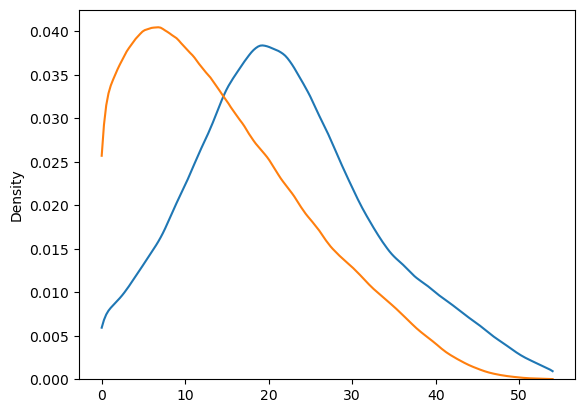

In [98]:
sns.kdeplot(baars_may_samp, cut=0)
sns.kdeplot(baars_man_samp, cut=0)

<Axes: ylabel='Density'>

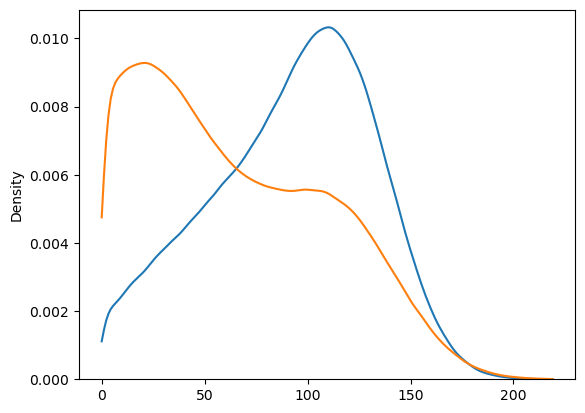

In [99]:
sns.kdeplot(hitop_may_samp, cut=0)
sns.kdeplot(hitop_man_samp, cut=0)

In [100]:
hitop_samp = np.hstack([hitop_may_samp, hitop_man_samp])
baars_samp = np.hstack([baars_may_samp, baars_man_samp])
ma_samp = np.hstack([np.ones(pop_size), np.zeros(pop_size)])

In [104]:
samp = pd.DataFrame(data=np.array([baars_samp, hitop_samp, ma_samp.astype(bool)]).T, columns=['baars_sum', 'hitop_sum', 'moodanxiety_bothered'])

In [109]:
samp['moodanxiety_bothered'] = samp.moodanxiety_bothered.astype(bool)

In [110]:
samp['baars_bin'] = pd.cut(samp.baars_sum, nbins, labels=False)
samp['hitop_bin'] = pd.cut(samp.hitop_sum, nbins, labels=False)

In [189]:
perm_res = []
for permn in range(nperms):
    perm_tmp = mutual_info_classif(samp.loc[:, ['baars_sum', 'baars_bin', 'hitop_sum' ,'hitop_bin']],
                            samp.moodanxiety_bothered.sample(frac=1, replace=False).values,
                            discrete_features=[False, True, False, True], n_neighbors=k)
    perm_nn = perm_tmp[0] - perm_tmp[2]
    perm_bin = perm_tmp[1] - perm_tmp[3]
    perm_res.append([perm_nn, perm_bin])
perm_res = np.array(perm_res)
perm_limits = np.quantile(perm_res, [0.025, 0.975], axis=0)

In [190]:
perm_limits

array([[ 3.56692685e-04, -5.29775244e-05],
       [ 1.68845374e-03, -3.03808798e-05]])

In [191]:
tmp = mutual_info_classif(samp.loc[:, ['baars_sum', 'baars_bin', 'hitop_sum' ,'hitop_bin']],
                    samp.moodanxiety_bothered,
                    discrete_features=[False, True, False, True])

In [192]:
hitop_wins_nn = (tmp[0] - tmp[2]) < perm_limits[0][0]
baars_wins_nn = (tmp[0] - tmp[2]) > perm_limits[1][0]
hitop_wins_bin = (tmp[1] - tmp[3]) < perm_limits[0][1]
baars_wins_bin = (tmp[1] - tmp[3]) > perm_limits[1][1]
hitop_wins_nn, baars_wins_nn, hitop_wins_bin, baars_wins_bin

(False, True, False, True)

In [116]:
subsamp_size = 500

In [117]:
samp.query('moodanxiety_bothered').sample(n=subsamp_size)

,baars_sum,hitop_sum,moodanxiety_bothered,baars_bin,hitop_bin
315771,35.0,43.0,True,916,277
580936,23.0,126.0,True,602,813
158992,17.0,138.0,True,445,891
31002,28.0,110.0,True,733,710
90954,42.0,20.0,True,1099,129
...,...,...,...,...,...
15460,47.0,95.0,True,1230,613
862101,42.0,107.0,True,1099,690
536112,37.0,107.0,True,968,690
636666,28.0,61.0,True,733,393


In [128]:
int(np.round(np.sqrt(2 * subsamp_size)))

32

In [156]:
0.06674662 - 0.05388547, 0.06167399 -  0.0528932

(0.012861150000000009, 0.008780789999999997)

In [272]:
subsamp_size = 250
ks = np.arange(1, 11).astype(int)
nbins = (np.arange(1, 11) / 5 *  np.round(np.sqrt(2 * subsamp_size))).astype(int)
n_subsamps = 100
nperms = 500
res = []
#for k, subsamp_nbins in zip(ks, nbins):
k = 3
subsamp_nbins = 22
rsix = 0
for ssn in range(n_subsamps):
        subsamp = pd.concat([samp.query('moodanxiety_bothered').sample(n=subsamp_size, replace=False, random_state=random_states[rsix]),
                             samp.query('~moodanxiety_bothered').sample(n=subsamp_size, replace=False, random_state=random_states[rsix])])
        subsamp['baars_bin'] = pd.cut(subsamp.baars_sum, subsamp_nbins, labels=False)
        subsamp['hitop_bin'] = pd.cut(subsamp.hitop_sum, subsamp_nbins, labels=False)
        tmp = mutual_info_classif(subsamp.loc[:, ['baars_sum', 'baars_bin', 'hitop_sum' ,'hitop_bin']],
                        subsamp.moodanxiety_bothered,
                        discrete_features=[False, True, False, True], n_neighbors=k)

        perm_res = []
        for permn in range(nperms):
            perm_tmp = mutual_info_classif(subsamp.loc[:, ['baars_sum', 'baars_bin', 'hitop_sum' ,'hitop_bin']],
                                    subsamp.moodanxiety_bothered.iloc[perms[permn]].values,
                                    discrete_features=[False, True, False, True], n_neighbors=k)
            perm_nn = perm_tmp[0] - perm_tmp[2]
            perm_bin = perm_tmp[1] - perm_tmp[3]
            perm_res.append([perm_nn, perm_bin])
        perm_res = np.array(perm_res)
        perm_limits = np.quantile(perm_res, [0.025, 0.975], axis=0)
        

        row = dict(
            subsamp_size=subsamp_size,
            subsamp_nbins=subsamp_nbins,
            k=k,
            ssn=ssn,
            baars_nn=tmp[0],
            baars_bin=tmp[1],
            hitop_nn=tmp[2],
            hitop_bin=tmp[3],
            hitop_wins_nn = (tmp[0] - tmp[2]) < perm_limits[0][0],
            baars_wins_nn = (tmp[0] - tmp[2]) > perm_limits[1][0],
            hitop_wins_bin = (tmp[1] - tmp[3]) < perm_limits[0][1],
            baars_wins_bin = (tmp[1] - tmp[3]) > perm_limits[1][1]
        )
        res.append(row)
        rsix += 1
res = pd.DataFrame(res)


In [273]:
def run_sim(k, subsamp_nbins, ssn, samp, perms, subsamp_size, nperms, n_subsamps, random_state):
    subsamp = pd.concat([samp.query('moodanxiety_bothered').sample(n=subsamp_size, random_state=random_state, replace=False),
                         samp.query('~moodanxiety_bothered').sample(n=subsamp_size, random_state=random_state, replace=False)])
    subsamp['baars_bi n'] = pd.cut(subsamp.baars_sum, subsamp_nbins, labels=False)
    subsamp['hitop_bin'] = pd.cut(subsamp.hitop_sum, subsamp_nbins, labels=False)
    tmp = mutual_info_classif(subsamp.loc[:, ['baars_sum', 'baars_bin', 'hitop_sum' ,'hitop_bin']],
                    subsamp.moodanxiety_bothered,
                    discrete_features=[False, True, False, True], n_neighbors=k)

    perm_res = []
    for permn in range(nperms):
        perm_tmp = mutual_info_classif(subsamp.loc[:, ['baars_sum', 'baars_bin', 'hitop_sum' ,'hitop_bin']],
                                subsamp.moodanxiety_bothered.iloc[perms[permn]].values,
                                discrete_features=[False, True, False, True], n_neighbors=k)
        perm_nn = perm_tmp[0] - perm_tmp[2]
        perm_bin = perm_tmp[1] - perm_tmp[3]
        perm_res.append([perm_nn, perm_bin])
    perm_res = np.array(perm_res)
    perm_limits = np.quantile(perm_res, [0.025, 0.975], axis=0)
    

    row = dict(
        subsamp_size=subsamp_size,
        subsamp_nbins=subsamp_nbins,
        k=k,
        ssn=ssn,
        baars_nn=tmp[0],
        baars_bin=tmp[1],
        hitop_nn=tmp[2],
        hitop_bin=tmp[3],
        hitop_wins_nn = (tmp[0] - tmp[2]) < perm_limits[0][0],
        baars_wins_nn = (tmp[0] - tmp[2]) > perm_limits[1][0],
        hitop_wins_bin = (tmp[1] - tmp[3]) < perm_limits[0][1],
        baars_wins_bin = (tmp[1] - tmp[3]) > perm_limits[1][1]
    )
    return row

In [204]:
from joblib import Parallel, delayed

In [280]:
jobs = []
rsix = 0
for k, subsamp_nbins in zip(ks, nbins):
    for ssn in range(n_subsamps):
        jobs.append(delayed(run_sim)(k, subsamp_nbins, ssn, samp, perms, subsamp_size, nperms, n_subsamps, random_states[rsix]))
        rsix += 1

In [281]:
pres = Parallel(n_jobs=1, verbose=10)(jobs)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   16.9s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:   30.6s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:   52.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.6min
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:  4.4min
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:  5.2min
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:  6.1min
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:  7.1min
[Parallel(n_jobs=1)]: Done 112 tasks      | elapsed:  8.2min
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:  9.3min
[Parallel(n_jobs=1)]: Done 144 tasks      | elapsed: 10.5min
[Parallel(n_jobs=1)]: Do

In [276]:
res = pd.DataFrame(res)

In [282]:
pres = pd.DataFrame(pres)

In [278]:
res.groupby(['subsamp_nbins', 'k'])[['hitop_wins_nn', 'baars_wins_nn', 'hitop_wins_bin', 'baars_wins_bin']].mean()

,,hitop_wins_nn,baars_wins_nn,hitop_wins_bin,baars_wins_bin
subsamp_nbins,k,,,,
22,3,0.06,0.2,0.1,0.32


In [283]:
pres.groupby(['subsamp_nbins', 'k'])[['hitop_wins_nn', 'baars_wins_nn', 'hitop_wins_bin', 'baars_wins_bin']].mean()

,,hitop_wins_nn,baars_wins_nn,hitop_wins_bin,baars_wins_bin
subsamp_nbins,k,,,,
4,1,0.07,0.15,0.08,0.32
8,2,0.09,0.19,0.10,0.27
13,3,0.08,0.22,0.11,0.19
17,4,0.11,0.19,0.09,0.15
22,5,0.13,0.22,0.13,0.21
26,6,0.07,0.25,0.07,0.20
30,7,0.09,0.32,0.11,0.21
35,8,0.20,0.21,0.13,0.17
39,9,0.11,0.30,0.13,0.14


In [209]:
res.groupby(['subsamp_nbins', 'k'])[['hitop_wins_nn', 'baars_wins_nn', 'hitop_wins_bin', 'baars_wins_bin']].mean()

,,hitop_wins_nn,baars_wins_nn,hitop_wins_bin,baars_wins_bin
subsamp_nbins,k,,,,
4,1,0.11,0.17,0.19,0.49
8,2,0.10,0.19,0.17,0.43
13,3,0.15,0.25,0.19,0.38
17,4,0.08,0.23,0.11,0.36
22,5,0.14,0.24,0.22,0.30
26,6,0.11,0.31,0.09,0.29
30,7,0.18,0.23,0.22,0.20
35,8,0.08,0.20,0.09,0.17
39,9,0.11,0.24,0.14,0.18


In [165]:
res.groupby('subsamp_nbins')[['baars_bin', 'hitop_bin']].agg(['mean', 'std']).reset_index()

In [175]:
perm_limits

array([[-0.02208481, -0.0238099 ],
       [ 0.02258161,  0.02057576]])

In [176]:
hitop_wins_nn = (tmp[0] - tmp[2]) < perm_limits[0][0]
baars_wins_nn = (tmp[0] - tmp[2]) > perm_limits[1][0]

hitop_wins_bin = (tmp[1] - tmp[3]) < perm_limits[0][1]
baars_wins_bin = (tmp[1] - tmp[3]) > perm_limits[1][1]

True

In [151]:
foo = res.groupby('subsamp_nbins')[['baars_bin', 'hitop_bin']].agg(['mean', 'std']).reset_index()
foo

subsamp_nbins baars_bin           hitop_bin          
                     mean       std      mean       std
0             4  0.053484  0.011841  0.050355  0.012246
1             8  0.063607  0.015519  0.057456  0.014669
2            13  0.075233  0.015958  0.066450  0.014754
3            17  0.078060  0.014794  0.069746  0.015349
4            22  0.082277  0.015769  0.074199  0.017698
5            26  0.088152  0.018149  0.078265  0.013937
6            30  0.092696  0.016558  0.080127  0.015571
7            35  0.100009  0.016220  0.091126  0.017315
8            39  0.098770  0.018710  0.093858  0.019388
9            44  0.106149  0.018635  0.097123  0.016836

In [152]:
foo = res.groupby('k')[['baars_nn', 'hitop_nn']].agg(['mean', 'std']).reset_index()
foo

k  baars_nn            hitop_nn          
           mean       std      mean       std
0   1  0.061428  0.032093  0.062568  0.034816
1   2  0.059856  0.027051  0.052385  0.028959
2   3  0.063281  0.027152  0.055069  0.025714
3   4  0.062167  0.021370  0.052193  0.021914
4   5  0.064447  0.021517  0.052910  0.022426
5   6  0.065412  0.024183  0.049475  0.018036
6   7  0.065478  0.021339  0.049243  0.017274
7   8  0.068029  0.020084  0.054143  0.019654
8   9  0.061704  0.022126  0.051797  0.020882
9  10  0.066142  0.020798  0.050457  0.017536

In [153]:
res['nn_dif'] = res.baars_nn - res.hitop_nn
res['bin_dif'] = res.baars_bin - res.hitop_bin

In [158]:
0.06674662 - 0.05388547, 0.06167399 -  0.0528932

(0.012861150000000009, 0.008780789999999997)

In [157]:
np.sqrt(500)

22.360679774997898

In [155]:
res.groupby(['subsamp_nbins', 'k'])[['nn_dif', 'bin_dif']].agg(['mean', 'std'])

nn_dif             bin_dif          
                      mean       std      mean       std
subsamp_nbins k                                         
4             1  -0.001140  0.044785  0.003129  0.016512
8             2   0.007472  0.036091  0.006151  0.022447
13            3   0.008212  0.037462  0.008783  0.020050
17            4   0.009974  0.032319  0.008314  0.021961
22            5   0.011537  0.028888  0.008078  0.021249
26            6   0.015937  0.031098  0.009887  0.023035
30            7   0.016235  0.027071  0.012569  0.022393
35            8   0.013886  0.030606  0.008883  0.024810
39            9   0.009907  0.030752  0.004912  0.025700
44            10  0.015685  0.027917  0.009027  0.026347

In [144]:
res.groupby(['subsamp_nbins', 'k'])[['baars_nn', 'baars_bin', 'hitop_nn', 'hitop_bin']].std()

,,baars_nn,baars_bin,hitop_nn,hitop_bin
subsamp_nbins,k,,,,
4,1,0.032093,0.011841,0.034816,0.012246
8,2,0.027051,0.015519,0.028959,0.014669
13,3,0.027152,0.015958,0.025714,0.014754
17,4,0.021370,0.014794,0.021914,0.015349
22,5,0.021517,0.015769,0.022426,0.017698
26,6,0.024183,0.018149,0.018036,0.013937
30,7,0.021339,0.016558,0.017274,0.015571
35,8,0.020084,0.016220,0.019654,0.017315
39,9,0.022126,0.018710,0.020882,0.019388


In [127]:
res.mean(0)

array([0.06038803, 0.07631897, 0.05080605, 0.06764226])

In [125]:
res.std(0)

array([0.01764324, 0.01076886, 0.01711236, 0.00929768])

In [115]:
mutual_info_classif(subsamp.loc[:, ['baars_sum', 'baars_bin', 'hitop_sum' ,'hitop_bin']],
                    subsamp.moodanxiety_bothered,
                    discrete_features=[False, True, False, True])

array([0.04335648, 0.07345555, 0.08546115, 0.17132052])

In [18]:
print(mutual_info_classif(dat.loc[:, ['baars_sum', 'hitop_sum']], dat.moodanxiety_bothered, discrete_features=False))
fig, axes = plt.subplots(2)
sns.histplot(data=dat, x='baars_sum', hue='moodanxiety_bothered', ax=axes[0])
sns.histplot(data=dat, x='hitop_sum', hue='moodanxiety_bothered', ax=axes[1])
fig.tight_layout()

AttributeError: 'DataFrame' object has no attribute 'moodanxiety_bothered'

[0.07686866 0.49018621]


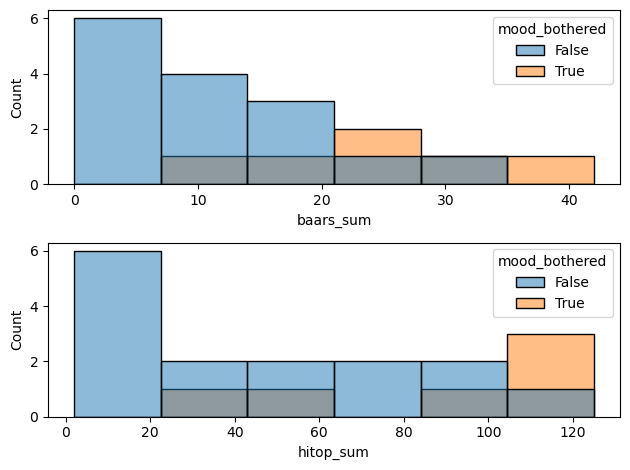

In [284]:

print(mutual_info_classif(dat.query("passed_grid").loc[:, ['baars_sum', 'hitop_sum']], dat.query("passed_grid").mood_bothered, discrete_features=False))

fig, axes = plt.subplots(2)
sns.histplot(data=dat.query("passed_grid"), x='baars_sum', hue='mood_bothered', ax=axes[0])
sns.histplot(data=dat.query("passed_grid"), x='hitop_sum', hue='mood_bothered', ax=axes[1])
fig.tight_layout()

[0.08508065 0.52837025]


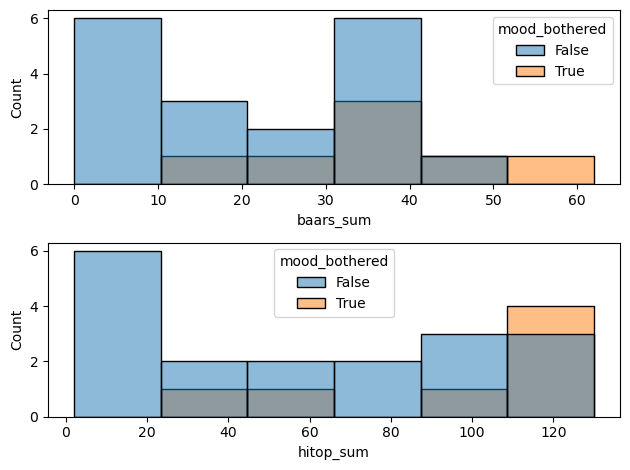

In [233]:

print(mutual_info_classif(dat.loc[:, ['baars_sum', 'hitop_sum']], dat.mood_bothered, discrete_features=False))

fig, axes = plt.subplots(2)
sns.histplot(data=dat, x='baars_sum', hue='mood_bothered', ax=axes[0])
sns.histplot(data=dat, x='hitop_sum', hue='mood_bothered', ax=axes[1])
fig.tight_layout()

In [219]:
mutual_info_classif(dat.loc[:, ['baars_sum', 'hitop_sum']], dat.anxiety_bothered, discrete_features=False)

array([0.2537547 , 0.08910314])

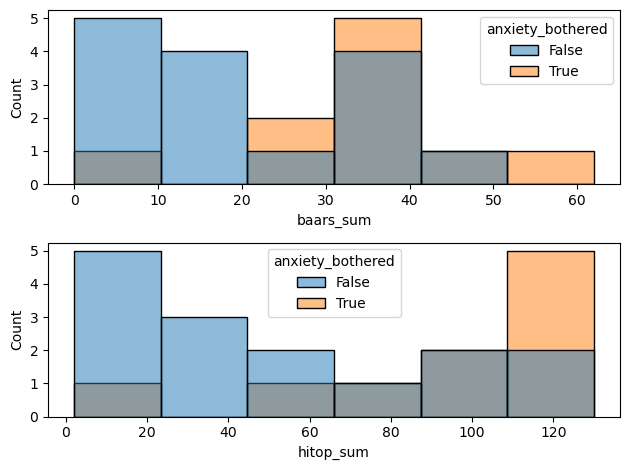

In [232]:
fig, axes = plt.subplots(2)
sns.histplot(data=dat, x='baars_sum', hue='anxiety_bothered', ax=axes[0])
sns.histplot(data=dat, x='hitop_sum', hue='anxiety_bothered', ax=axes[1])
fig.tight_layout()

In [220]:
mutual_info_classif(dat.loc[:, ['baars_sum', 'hitop_sum']], dat.attention_bothered, discrete_features=False)

array([0.07148552, 0.01092682])

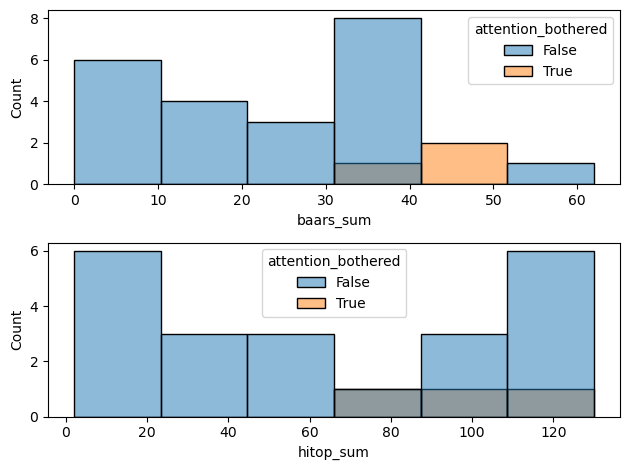

In [231]:
fig, axes = plt.subplots(2)
sns.histplot(data=dat, x='baars_sum', hue='attention_bothered', ax=axes[0])
sns.histplot(data=dat, x='hitop_sum', hue='attention_bothered', ax=axes[1])
fig.tight_layout()

<Axes: xlabel='hitop_sum', ylabel='Count'>

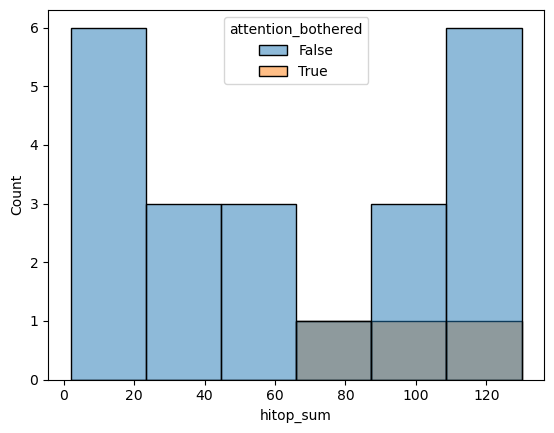

In [226]:
sns.histplot(data=dat, x='hitop_sum', hue='attention_bothered')

In [204]:
mutual_info_classif(dat.loc[:, ['passed_checks', 'passed_grid', 'passed_list']], dat.baars_sum, discrete_features=True)

array([0.52158472, 0.43966988, 0.49503598])

In [208]:
dat.shape

(25, 411)

In [ ]:
stats.fisher_exact(

In [184]:
stats.spearmanr(dat.baars_sum, dat.hitop_sum), stats.spearmanr(ok_dat.baars_sum, ok_dat.hitop_sum)

(SignificanceResult(statistic=0.8405549823394931, pvalue=1.451336536537333e-07),
 SignificanceResult(statistic=0.9086902343725689, pvalue=1.111493965159416e-06))

In [170]:
stats.spearmanr(dat.phq_sum, dat.anhedonic_depression), stats.spearmanr(ok_dat.phq_sum, ok_dat.anhedonic_depression)

(SignificanceResult(statistic=0.8952161108383018, pvalue=1.5370225535516053e-09),
 SignificanceResult(statistic=0.945688712136862, pvalue=3.2356834827465695e-08))

In [171]:
stats.spearmanr(dat.gad_sum, dat.anxious_worry), stats.spearmanr(ok_dat.gad_sum, ok_dat.anxious_worry)

(SignificanceResult(statistic=0.8513986656504904, pvalue=6.828982306422666e-08),
 SignificanceResult(statistic=0.8959881129271917, pvalue=2.671757887997061e-06))

In [172]:
stats.spearmanr(dat.phq_sum, dat.well_being), stats.spearmanr(ok_dat.phq_sum, ok_dat.well_being)

(SignificanceResult(statistic=-0.8050305194588487, pvalue=1.2182284688999098e-06),
 SignificanceResult(statistic=-0.8560981624510337, pvalue=2.3218411902249017e-05))

In [141]:
baars_score_cols = ['inattention_sum',
 'hyperactivity_sum',
 'impulsivity_sum',
 'sct_sum','baars_sum']

In [180]:
ok_dat = dat.query("passed_checks")

In [146]:
ok_dat.groupby('attention_bothered')[baars_score_cols].describe()

inattention_sum                                          \
                             count       mean       std   min    25%   50%   
attention_bothered                                                           
False                         14.0   7.857143  7.230886   0.0   2.25   6.0   
True                           2.0  14.500000  3.535534  12.0  13.25  14.5   

                                hyperactivity_sum                           \
                      75%   max             count      mean       std  min   
attention_bothered                                                           
False               12.25  25.0              14.0  2.857143  3.207135  0.0   
True                15.75  17.0               2.0  6.000000  1.414214  5.0   

                                        impulsivity_sum                      \
                    25%  50%  75%   max           count mean       std  min   
attention_bothered                                                            
False               1.0  2.0  3.0  11.0            14.0  2.0  2.112235  0.0   
True                5.5  6.0  6.5   7.0             2.0  4.5  6.363961  0.0   

                                         sct_sum                             \
                     25%  50%   75%  max   count       mean       std   min   
attention_bothered                                                            
False               1.00  1.5  2.00  7.0    14.0   8.285714  7.226325   0.0   
True                2.25  4.5  6.75  9.0     2.0  17.500000  0.707107  17.0   

                                             baars_sum                         \
                      25%   50%    75%   max     count  mean        std   min   
attention_bothered                                                              
False                2.25   7.5  13.75  20.0      14.0  21.0  18.021355   0.0   
True                17.25  17.5  17.75  18.0       2.0  42.5  10.606602  35.0   

                                              
                      25%   50%    75%   max  
attention_bothered                            
False                6.25  17.0  34.00  62.0  
True                38.75  42.5  46.25  50.0

In [136]:
dat.groupby(['mood_bothered', 'anxiety_bothered'])[['phq_sum','gad_sum']].describe()

phq_sum                                    \
                                 count       mean       std   min    25%   
mood_bothered anxiety_bothered                                             
False         False               14.0   6.142857  6.689339   0.0   1.00   
              True                 4.0   6.250000  5.057997   0.0   3.75   
True          False                1.0   5.000000       NaN   5.0   5.00   
              True                 6.0  17.333333  3.777124  11.0  16.25   

                                                  gad_sum             \
                                 50%    75%   max   count       mean   
mood_bothered anxiety_bothered                                         
False         False              3.5  10.75  20.0    14.0   5.000000   
              True               6.5   9.00  12.0     4.0   8.750000   
True          False              5.0   5.00   5.0     1.0   2.000000   
              True              17.5  19.50  22.0     6.0  14.166667   

                                                                          
                                     std   min    25%   50%    75%   max  
mood_bothered anxiety_bothered                                            
False         False             5.392302   0.0   0.25   2.5  10.75  14.0  
              True              5.909033   3.0   4.50   8.0  12.25  16.0  
True          False                  NaN   2.0   2.00   2.0   2.00   2.0  
              True              1.722401  12.0  13.25  14.0  14.75  17.0

In [123]:
dat.loc[:, cols].sum(1)

0     131
1      38
2      20
3     137
4     119
5     101
6      38
7      78
8      80
9      74
10     29
11    130
12     49
13    120
14     63
15     27
16     55
17     78
18    126
19    109
20    134
21    120
22     50
23    121
24     34
dtype: int64

In [67]:
dat.loc[dat.mood_bothered, dat.columns.str.contains('phq')].sum(1)

5     36
7     34
11    33
12    27
13    40
20    40
21    39
dtype: int64

In [66]:
dat.loc[~dat.mood_bothered, dat.columns.str.contains('phq')].sum(1)

0     32
1     24
2     24
3     33
4     30
6     24
8     27
9     28
10    25
14    24
15    24
16    27
17    31
18    38
19    34
22    24
23    38
24    25
dtype: int64

In [72]:
dat.loc[dat.anxiety_bothered, dat.columns.str.contains('gad')].sum(1)

0     34
5     31
6     22
7     30
8     22
11    30
13    32
19    31
20    32
21    34
dtype: int64

In [73]:
dat.loc[~dat.anxiety_bothered, dat.columns.str.contains('gad')].sum(1)

1     21
2     21
3     32
4     28
9     24
10    22
12    23
14    24
15    21
16    23
17    26
18    28
22    21
23    31
24    22
dtype: int64

In [76]:
dat.loc[~dat.attention_bothered, dat.columns.str.contains('baars')].sum(1)

0     0.0
1     0.0
2     0.0
3     0.0
5     0.0
6     0.0
7     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
22    0.0
23    0.0
24    0.0
dtype: float64

In [78]:
dat.columns.str.contains('inattention')

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [80]:
dat.loc[~dat.attention_bothered, dat.columns.str.contains('inattention')].sum(1)

0     37
1     27
2     27
3     36
5     43
6     28
7     37
9     31
10    33
11    35
12    33
13    37
14    34
15    27
16    28
17    30
18    33
19    30
20    49
22    30
23    38
24    31
dtype: int64